In [1]:
import os
import h5py
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_attrs(digit_struct_mat_file, index):
    """
    Returns a dictionary which contains keys: label, left, top, width and height, each key has multiple values.
    """
    attrs = {}
    f = digit_struct_mat_file
    item = f['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = f[item][key]
        values = [f[attr.value[i].item()].value[0][0]
                  for i in range(len(attr))] if len(attr) > 1 else [attr.value[0][0]]
        attrs[key] = values
    return attrs

In [3]:
path_to_dir = '/home/mipal/dataset/svhn/test'
path_to_digit_struct_mat_file = os.path.join(path_to_dir, 'digitStruct.mat')

In [4]:
path_to_image_file = os.path.join(path_to_dir, '57.png')
index = int(path_to_image_file.split('/')[-1].split('.')[0]) - 1
print('index %d: %s' % (index, path_to_image_file))

index 56: /home/mipal/dataset/svhn/test/57.png


In [5]:
with h5py.File(path_to_digit_struct_mat_file, 'r') as digit_struct_mat_file:
    attrs = get_attrs(digit_struct_mat_file, index)
    length = len(attrs['label'])
    attrs_left, attrs_top, attrs_width, attrs_height = map(lambda x: [int(i) for i in x],
                                                       [attrs['left'], attrs['top'], attrs['width'], attrs['height']])
    min_left, min_top, max_right, max_bottom = (min(attrs_left),
                                                min(attrs_top),
                                                max(map(lambda x, y: x + y, attrs_left, attrs_width)),
                                                max(map(lambda x, y: x + y, attrs_top, attrs_height)))
    center_x, center_y, max_side = ((min_left + max_right) / 2.0,
                                    (min_top + max_bottom) / 2.0,
                                    max(max_right - min_left, max_bottom - min_top))
    bbox_left, bbox_top, bbox_width, bbox_height = (center_x - max_side / 2.0, 
                                                    center_y - max_side / 2.0, 
                                                    max_side,
                                                    max_side)
    cropped_left, cropped_top, cropped_width, cropped_height = (int(round(bbox_left - 0.15 * bbox_width)),
                                                                int(round(bbox_top - 0.15 * bbox_height)),
                                                                int(round(bbox_width * 1.3)),
                                                                int(round(bbox_height * 1.3)))
print('min_left=%d, min_top=%d, max_right=%d, max_bottom=%d' % (min_left, min_top, max_right, max_bottom))
print('center_x=%.1f, center_y=%.1f, max_side=%d' % (center_x, center_y, max_side))
print('bbox: left=%.1f, top=%.1f, width=%d, height=%d' % (bbox_left, bbox_top, bbox_width, bbox_height))
print('cropped: left=%d, top=%d, width=%d, height=%d' % (cropped_left, cropped_top, cropped_width, cropped_height))

min_left=40, min_top=11, max_right=74, max_bottom=31
center_x=57.0, center_y=21.0, max_side=34
bbox: left=40.0, top=4.0, width=34, height=34
cropped: left=35, top=-1, width=44, height=44


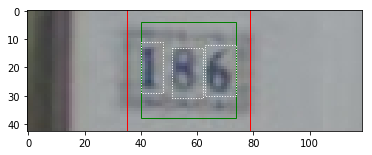

In [6]:
image = Image.open(path_to_image_file)
plt.figure()
currentAxis = plt.gca()
currentAxis.imshow(image)
currentAxis.add_patch(Rectangle((cropped_left, cropped_top), cropped_width, cropped_height, fill=False, edgecolor='red'))
currentAxis.add_patch(Rectangle((bbox_left, bbox_top), bbox_width, bbox_height, fill=False, edgecolor='green'))
for attr_left, attr_top, attr_width, attr_height in zip(attrs_left, attrs_top, attrs_width, attrs_height):
    currentAxis.add_patch(Rectangle((attr_left, attr_top), attr_width, attr_height, fill=False, edgecolor='white', linestyle='dotted'))
plt.show()